In [38]:
import pandas, numpy, seaborn, umap
import scipy, scipy.signal
import MulticoreTSNE

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':40})

# user-defined variables

In [3]:
expression_file = '/home/adrian/scratch/selected_expression.tsv'
output_dir = '/home/adrian/scratch/'

In [4]:
iso1 = 'ENST00000354449.7'
iso2 = 'ENST00000354956.9'

# read data

In [5]:
%%time
selected_expression = pandas.read_csv(expression_file, index_col=0, sep='\t')
print(selected_expression.shape)
selected_expression.head()

(46490, 4850)
CPU times: user 30.4 s, sys: 1.09 s, total: 31.5 s
Wall time: 31.5 s


,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-11ONC-2326-SM-5HL6P,GTEX-TSE9-0126-SM-3DB83,...,GTEX-144GO-0126-SM-5LUAO,GTEX-1313W-1626-SM-5J1OE,GTEX-12ZZY-1526-SM-5LZWF,GTEX-QMRM-0826-SM-3NB33,GTEX-ZYFD-2126-SM-5E43D,GTEX-OOBK-2626-SM-2HMKY,GTEX-1117F-2826-SM-5GZXL,GTEX-11ZTS-3326-SM-5LU9Y,GTEX-ZA64-2126-SM-5Q5A8,GTEX-XV7Q-0426-SM-4BRVN
sample,,,,,,,,,,,,,,,,,,,,,
ENST00000625998.2,2.172597,2.098120,0.604361,1.012243,2.112940,1.282651,2.350597,1.055977,2.268121,3.637061,...,0.979851,2.130198,1.992097,1.513298,0.000141,1.761416,2.140628,2.460868,1.539885,2.148756e+00
ENST00000583693.5,1.679476,1.659720,2.343766,2.182024,1.608522,2.342481,1.919266,2.462014,1.688779,2.058498,...,2.027438,1.520067,1.725912,2.402364,2.017785,2.313324,1.886362,3.031236,2.084875,1.991199e+00
ENST00000012134.6,0.028054,1.528813,1.308149,0.799196,2.200149,1.650502,1.646210,2.311007,2.369605,2.471435,...,1.576889,1.827558,2.260518,1.542512,3.450004,2.087475,1.687606,1.888114,1.929434,1.385126e+00
ENST00000403263.5,2.737514,2.433423,2.221165,2.084570,2.304542,2.238873,2.688859,2.615937,2.220693,2.446559,...,2.220222,2.060171,2.130275,2.778681,2.242817,1.937410,2.314922,2.136376,2.615435,1.944068e+00
ENST00000449352.6,1.695411,2.800497,2.215746,2.359610,2.831991,2.112632,2.839560,2.607822,2.999159,2.933138,...,3.785498,1.353480,2.671217,2.489579,2.637228,1.660130,1.744530,3.022813,2.252766,8.428712e-08


# quantile normalization

In [6]:
%%time
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(selected_expression.values, axis=0), index=selected_expression.index, columns=selected_expression.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = selected_expression.rank(method="min").stack().astype(int).map(df_mean).unstack()

CPU times: user 57.5 s, sys: 6.73 s, total: 1min 4s
Wall time: 1min 4s


14.632557278189001
4850


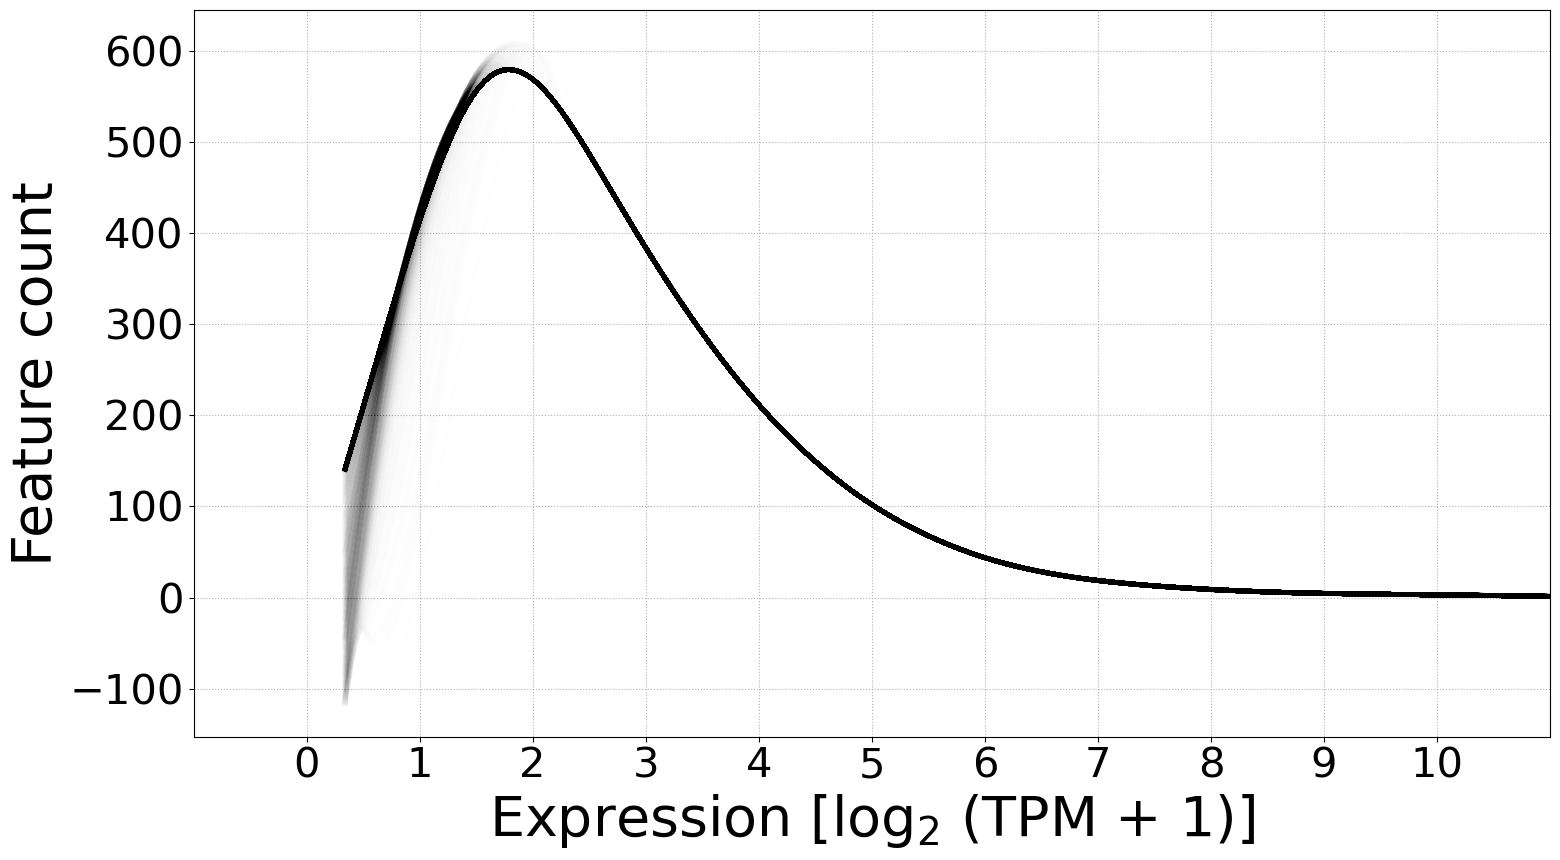

In [7]:
found_max = 19
resolution = 25
number_of_bins = found_max * resolution
absolute_max = 0
margin = int(resolution/3)

most_likely_expressions = []

selected_samples = []

for sample in qndf.columns:
        
    expression_values = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # determine most likely expression
    most_likely_expression = x[numpy.argmax(yhat)]
    most_likely_expressions.append(most_likely_expression)
    
    # sample selection
    if 1 <= most_likely_expression <= 2:
        selected_samples.append(sample)
    
    # plotting
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color='black')
    
    # check
    if numpy.max(expression_values) > absolute_max:
        absolute_max = numpy.max(expression_values)

# check print
print(absolute_max)
print(len(selected_samples))

matplotlib.pyplot.xlim(-1, 11)                  
matplotlib.pyplot.xticks(range(0, 10+1))
matplotlib.pyplot.xlabel('Expression [log$_2$ (TPM + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
# define highly variable genes.plot cv as a fucntion of mean.
# http://pklab.med.harvard.edu/scw2014/subpop_tutorial.html

# z-score

In [8]:
zscore_df = scipy.stats.zscore(qndf, axis=1)
zscore_df.std(axis=1)

sample
ENST00000625998.2    1.000103
ENST00000583693.5    1.000103
ENST00000012134.6    1.000103
ENST00000403263.5    1.000103
ENST00000449352.6    1.000103
                       ...   
ENST00000470412.5    1.000103
ENST00000469534.1    1.000103
ENST00000507412.1    1.000103
ENST00000568351.1    1.000103
ENST00000491408.1    1.000103
Length: 46490, dtype: float64

In [9]:
print(zscore_df.max().max())
print(zscore_df.min().min())

16.035577237299698
-17.83257350906713


# exploratory visualization

## heatmap

In [10]:
zscore_df.rename_axis('Transcripts', inplace=True)
zscore_df.rename_axis('Samples', axis='columns', inplace=True)
print(zscore_df.shape)
zscore_df

(46490, 4850)


Samples,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-11ONC-2326-SM-5HL6P,GTEX-TSE9-0126-SM-3DB83,...,GTEX-144GO-0126-SM-5LUAO,GTEX-1313W-1626-SM-5J1OE,GTEX-12ZZY-1526-SM-5LZWF,GTEX-QMRM-0826-SM-3NB33,GTEX-ZYFD-2126-SM-5E43D,GTEX-OOBK-2626-SM-2HMKY,GTEX-1117F-2826-SM-5GZXL,GTEX-11ZTS-3326-SM-5LU9Y,GTEX-ZA64-2126-SM-5Q5A8,GTEX-XV7Q-0426-SM-4BRVN
Transcripts,,,,,,,,,,,,,,,,,,,,,
ENST00000625998.2,0.263048,0.099419,-2.526438,-1.804144,-0.130980,-1.460529,0.692229,-1.985062,-0.001303,2.130159,...,-1.744595,0.034697,0.167124,-1.595629,-2.828311,-0.668420,-0.027320,0.229953,-1.075713,-0.259797
ENST00000583693.5,-0.073850,-0.310748,0.448507,0.500200,-1.070835,0.799277,0.690695,0.664133,-1.152902,0.079217,...,-0.089911,-1.098932,0.063114,0.114269,0.891392,0.793636,-0.274792,2.555237,0.018814,-0.354012
ENST00000012134.6,-1.832807,-0.252275,-1.107070,-1.662162,0.325733,-0.516594,0.027541,0.171570,0.474161,0.652383,...,-0.555573,-0.060827,0.853901,-1.136843,2.245518,0.158270,-0.398105,-0.225420,-0.143752,-0.890482
ENST00000403263.5,1.872036,0.861516,-0.852487,-0.720786,-0.026809,-0.379251,2.305309,0.342521,-0.520396,0.357068,...,-0.527013,-0.508494,0.486753,0.447563,0.752254,-1.246478,0.196111,-0.898288,0.823906,-1.572174
ENST00000449352.6,-0.728935,0.382982,-0.663683,-0.265099,0.265950,-0.636996,0.699918,-0.223612,0.453828,0.403994,...,1.291454,-1.430827,0.534282,-0.546308,0.375992,-1.167434,-1.036823,0.431816,-0.488016,-2.921104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000470412.5,-0.329007,-0.684363,1.524939,-0.879398,-0.308284,1.673239,0.619182,-0.852590,0.133280,2.122124,...,-0.342556,-0.191504,-1.150223,1.869432,-0.456774,-0.936708,0.100964,-1.138984,0.808606,2.456697
ENST00000469534.1,-0.616457,-0.462084,-1.147812,-1.246140,-0.451648,-0.461631,0.588264,-0.902669,2.171074,1.548757,...,0.164875,1.342339,-0.240896,-0.390366,-1.222641,-1.110530,0.745844,-0.791497,2.086631,-1.368309
ENST00000507412.1,1.291458,1.744660,-0.880080,-0.764095,1.608494,-0.088140,-1.121306,-0.761196,-0.776149,-0.371490,...,-0.553818,-0.726383,-0.723717,0.622930,1.168891,-0.449007,0.106188,0.368769,0.482753,2.062970


In [12]:
test

Samples,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-11ONC-2326-SM-5HL6P,GTEX-TSE9-0126-SM-3DB83,...,GTEX-13JUV-0011-R9a-SM-5LZX3,GTEX-RU72-1226-SM-2TF6N,GTEX-Y114-0008-SM-4TT8X,GTEX-14A6H-0126-SM-5QGPK,GTEX-131YS-2826-SM-5EQ47,GTEX-11TUW-0626-SM-5LU9M,GTEX-Y5V6-1626-SM-4VDT2,GTEX-QV31-1126-SM-4R1K4,GTEX-13PVQ-0426-SM-5J1OG,GTEX-WEY5-0526-SM-3GIKZ
Transcripts,,,,,,,,,,,,,,,,,,,,,
ENST00000625998.2,0.263048,0.099419,-2.526438,-1.804144,-0.130980,-1.460529,0.692229,-1.985062,-0.001303,2.130159,...,0.661820,-0.055044,-1.044937,0.327808,1.282814,2.153913,1.316644,1.145228,-0.785677,-1.269276
ENST00000583693.5,-0.073850,-0.310748,0.448507,0.500200,-1.070835,0.799277,0.690695,0.664133,-1.152902,0.079217,...,0.442106,-0.540433,-1.328872,0.611005,0.671447,1.111043,0.004176,-0.639784,0.302613,-0.208324
ENST00000012134.6,-1.832807,-0.252275,-1.107070,-1.662162,0.325733,-0.516594,0.027541,0.171570,0.474161,0.652383,...,1.199424,0.677923,0.157996,-1.499503,1.190997,-0.048120,-1.937586,-0.831784,-0.349146,-0.046933
ENST00000403263.5,1.872036,0.861516,-0.852487,-0.720786,-0.026809,-0.379251,2.305309,0.342521,-0.520396,0.357068,...,-1.212752,0.693027,-0.697123,1.802927,2.425196,3.026260,-0.090431,-2.385070,1.276447,0.966226
ENST00000449352.6,-0.728935,0.382982,-0.663683,-0.265099,0.265950,-0.636996,0.699918,-0.223612,0.453828,0.403994,...,-1.189338,2.282291,-2.958449,-1.210282,0.022488,1.618203,-0.209897,1.731344,0.827155,-0.761135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000348849.7,-1.648367,0.622758,-0.739115,0.258223,-0.185615,0.899691,-0.559297,-0.529517,-0.112998,-0.245164,...,-1.851919,0.459180,2.008090,0.248510,-0.716739,0.031064,-1.213468,-1.635133,-0.455917,-0.765463
ENST00000589795.1,-0.291642,0.607763,0.084599,-0.707091,1.276052,-0.663979,-0.466969,-1.041884,2.026985,-0.620593,...,1.572799,2.101699,-0.376551,-0.973977,-0.810689,-0.454811,-0.211052,0.599152,1.079209,-0.509860
ENST00000562949.1,0.218163,0.446954,0.248116,-0.077143,0.593208,-0.015268,0.756836,0.635139,0.147095,0.977166,...,0.382357,-0.002300,1.121336,-0.266320,0.144317,-0.032183,-1.150053,3.000870,-0.176932,0.735318


In [14]:
reduction = 10
test = zscore_df.iloc[:int(zscore_df.shape[0]/reduction), :int(zscore_df.shape[1]/reduction)] 
print(test.shape)
test

(4649, 485)


Samples,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-11ONC-2326-SM-5HL6P,GTEX-TSE9-0126-SM-3DB83,...,GTEX-13JUV-0011-R9a-SM-5LZX3,GTEX-RU72-1226-SM-2TF6N,GTEX-Y114-0008-SM-4TT8X,GTEX-14A6H-0126-SM-5QGPK,GTEX-131YS-2826-SM-5EQ47,GTEX-11TUW-0626-SM-5LU9M,GTEX-Y5V6-1626-SM-4VDT2,GTEX-QV31-1126-SM-4R1K4,GTEX-13PVQ-0426-SM-5J1OG,GTEX-WEY5-0526-SM-3GIKZ
Transcripts,,,,,,,,,,,,,,,,,,,,,
ENST00000625998.2,0.263048,0.099419,-2.526438,-1.804144,-0.130980,-1.460529,0.692229,-1.985062,-0.001303,2.130159,...,0.661820,-0.055044,-1.044937,0.327808,1.282814,2.153913,1.316644,1.145228,-0.785677,-1.269276
ENST00000583693.5,-0.073850,-0.310748,0.448507,0.500200,-1.070835,0.799277,0.690695,0.664133,-1.152902,0.079217,...,0.442106,-0.540433,-1.328872,0.611005,0.671447,1.111043,0.004176,-0.639784,0.302613,-0.208324
ENST00000012134.6,-1.832807,-0.252275,-1.107070,-1.662162,0.325733,-0.516594,0.027541,0.171570,0.474161,0.652383,...,1.199424,0.677923,0.157996,-1.499503,1.190997,-0.048120,-1.937586,-0.831784,-0.349146,-0.046933
ENST00000403263.5,1.872036,0.861516,-0.852487,-0.720786,-0.026809,-0.379251,2.305309,0.342521,-0.520396,0.357068,...,-1.212752,0.693027,-0.697123,1.802927,2.425196,3.026260,-0.090431,-2.385070,1.276447,0.966226
ENST00000449352.6,-0.728935,0.382982,-0.663683,-0.265099,0.265950,-0.636996,0.699918,-0.223612,0.453828,0.403994,...,-1.189338,2.282291,-2.958449,-1.210282,0.022488,1.618203,-0.209897,1.731344,0.827155,-0.761135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000348849.7,-1.648367,0.622758,-0.739115,0.258223,-0.185615,0.899691,-0.559297,-0.529517,-0.112998,-0.245164,...,-1.851919,0.459180,2.008090,0.248510,-0.716739,0.031064,-1.213468,-1.635133,-0.455917,-0.765463
ENST00000589795.1,-0.291642,0.607763,0.084599,-0.707091,1.276052,-0.663979,-0.466969,-1.041884,2.026985,-0.620593,...,1.572799,2.101699,-0.376551,-0.973977,-0.810689,-0.454811,-0.211052,0.599152,1.079209,-0.509860
ENST00000562949.1,0.218163,0.446954,0.248116,-0.077143,0.593208,-0.015268,0.756836,0.635139,0.147095,0.977166,...,0.382357,-0.002300,1.121336,-0.266320,0.144317,-0.032183,-1.150053,3.000870,-0.176932,0.735318


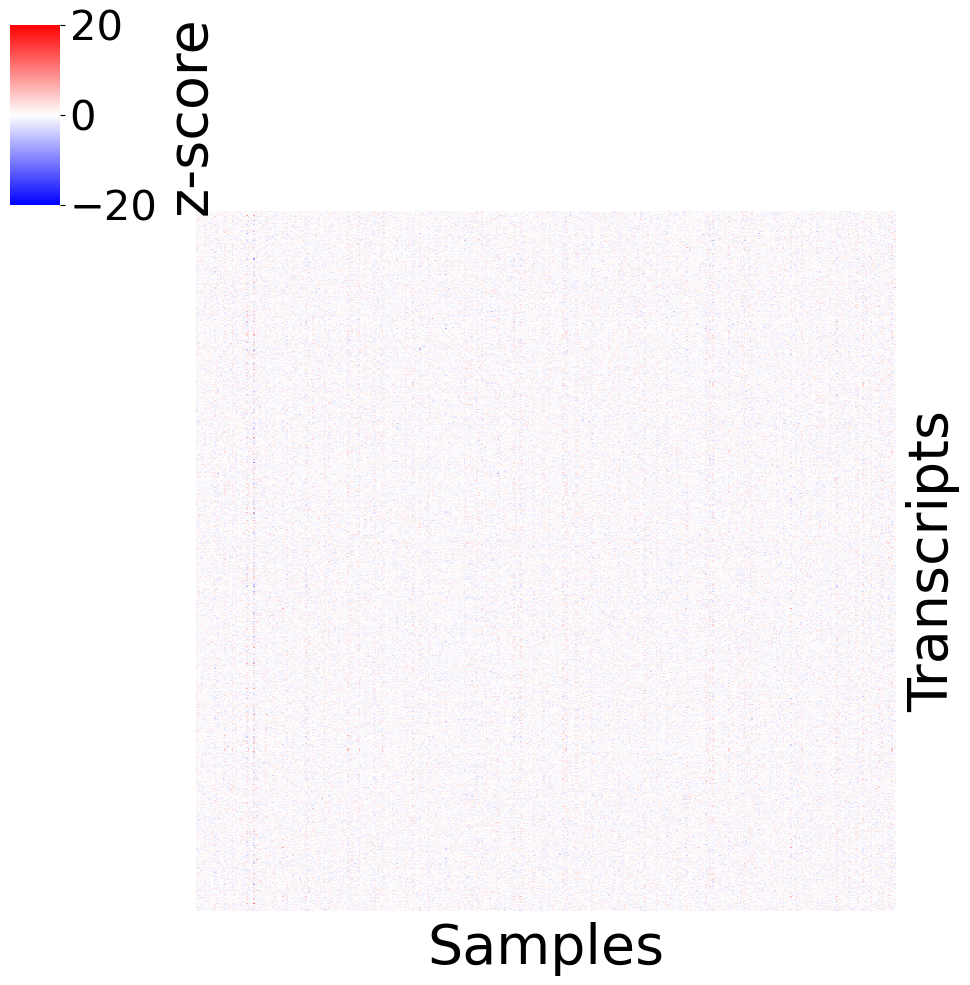

CPU times: user 1.29 s, sys: 265 µs, total: 1.29 s
Wall time: 1.29 s


In [15]:
%%time
seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=False, 
                   col_cluster=False, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                  )
matplotlib.pyplot.show()

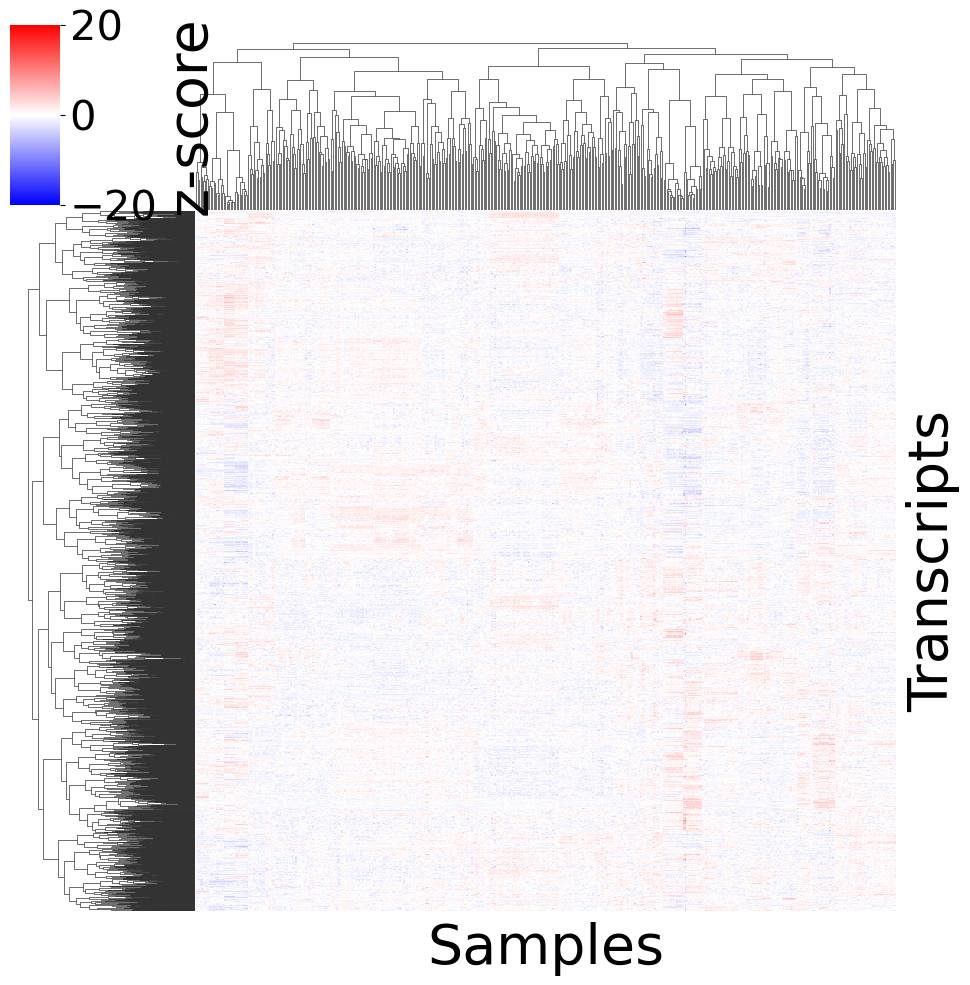

CPU times: user 4.01 s, sys: 221 µs, total: 4.01 s
Wall time: 4.01 s


In [16]:
%%time
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=True, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                   method=linkage_method, metric=distance_metric
                  )
matplotlib.pyplot.show()

## dimensionality reduction

In [18]:
### UMAP

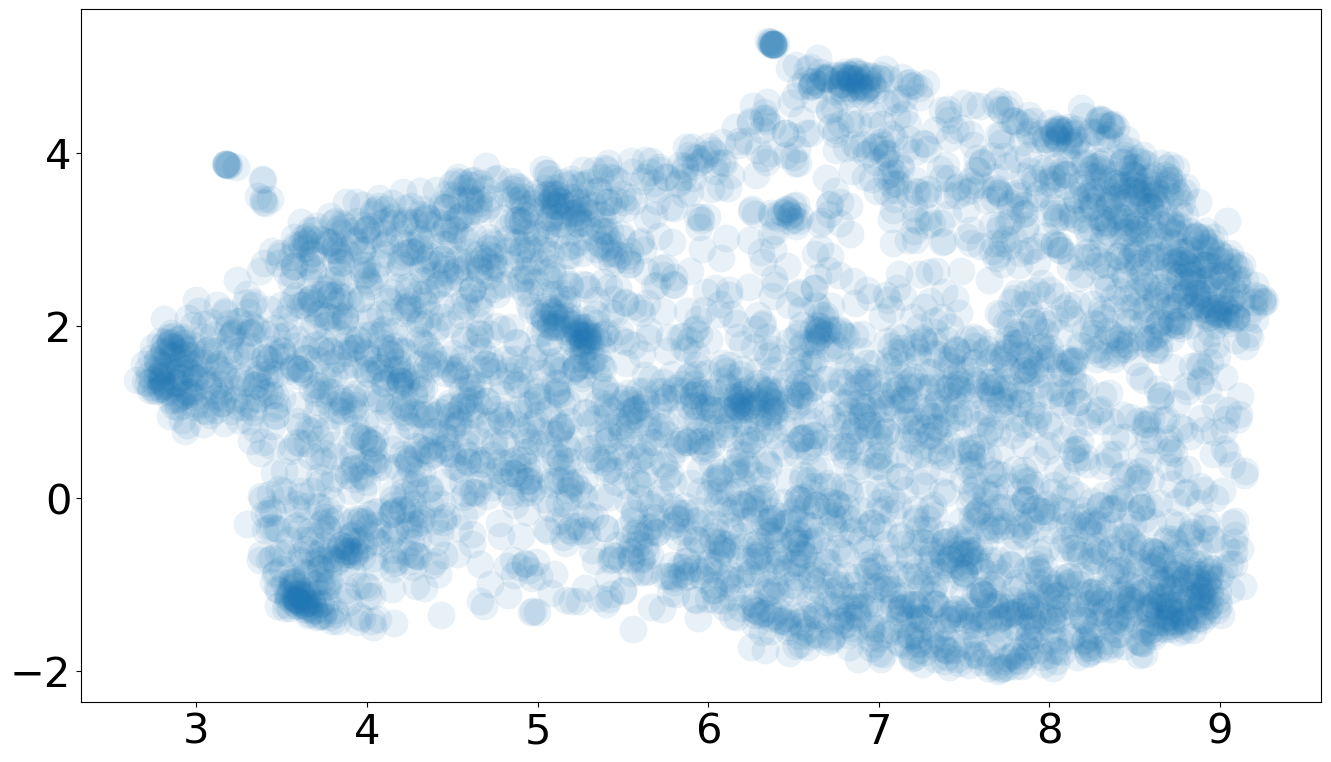

(4649, 2)


,X,Y
Transcripts,,
ENST00000625998.2,3.771879,2.446603
ENST00000583693.5,3.832914,1.611394
ENST00000012134.6,6.105522,1.479959
ENST00000403263.5,5.055918,3.401880
ENST00000449352.6,6.930329,1.343042
...,...,...
ENST00000348849.7,8.714200,3.215297
ENST00000589795.1,5.939273,2.082747
ENST00000562949.1,5.976481,-0.927690


In [36]:
runUmap = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='correlation').fit_transform
dr_umap = runUmap(test)
positionsu = pandas.DataFrame(dr_umap, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionsu['X'], positionsu['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20)
matplotlib.pyplot.show()

print(positionsu.shape)
positionsu

### tSNE

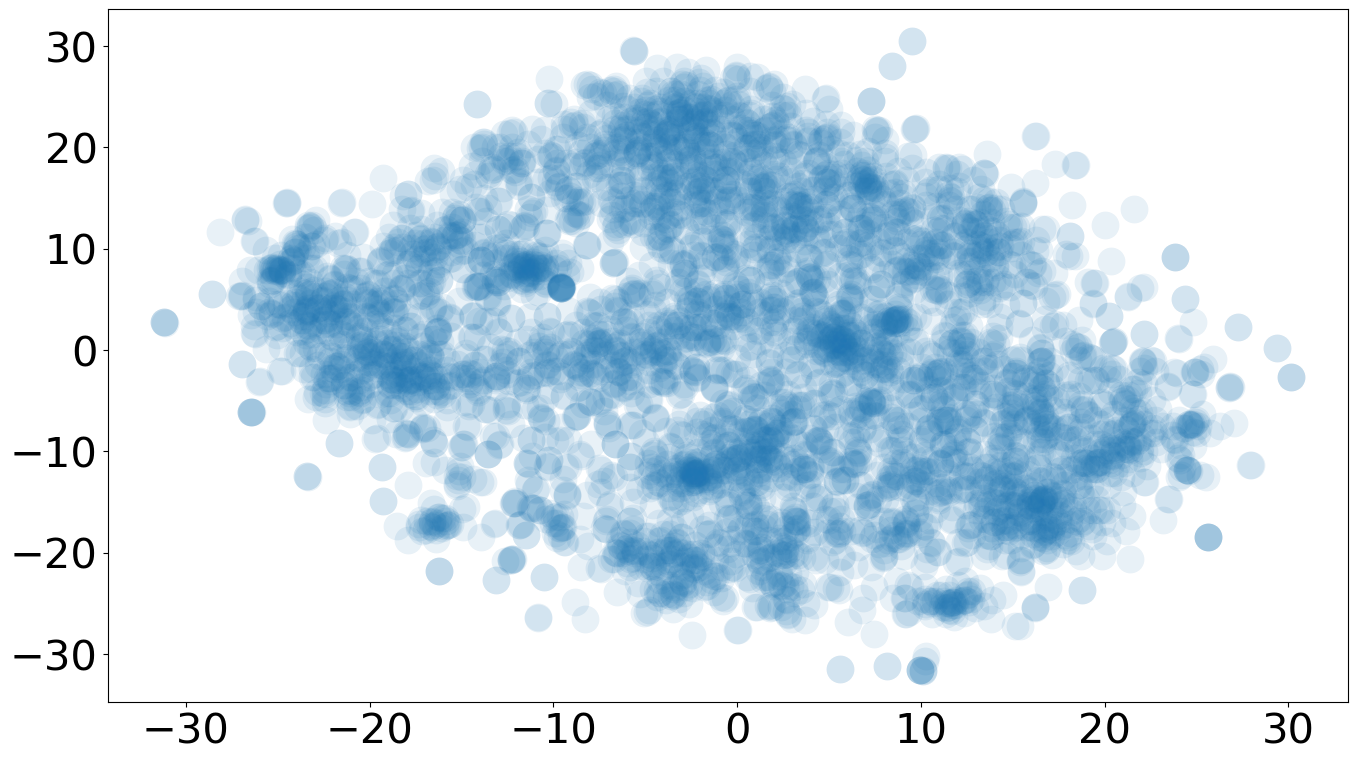

(4649, 2)


,X,Y
Transcripts,,
ENST00000625998.2,1.454709,-16.554246
ENST00000583693.5,10.332946,-11.963581
ENST00000012134.6,8.250311,0.735752
ENST00000403263.5,-3.408423,-19.361714
ENST00000449352.6,-5.340457,-5.340189
...,...,...
ENST00000348849.7,-23.270712,4.666724
ENST00000589795.1,-9.407893,-4.484044
ENST00000562949.1,12.900370,12.496412


In [44]:
tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=20)
dr_tsne = tsne.fit_transform(test)
positionst = pandas.DataFrame(dr_tsne, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionst['X'], positionst['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20)
matplotlib.pyplot.show()

print(positionst.shape)
positionst

# cluster data